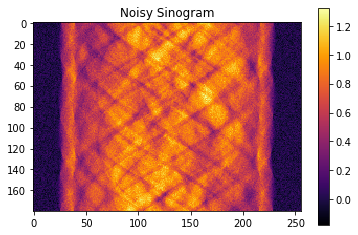

In [2]:
import numpy as np 
import numpy                          
import matplotlib.pyplot as plt

from ccpi.optimisation.algorithms import PDHG, SPDHG

from ccpi.optimisation.operators import BlockOperator, Identity, Gradient
from ccpi.optimisation.functions import ZeroFunction, L1Norm, \
                      MixedL21Norm, BlockFunction, L2NormSquared,\
                          KullbackLeibler, IndicatorBox, TotalVariation
from ccpi.framework import TestData, ImageGeometry, AcquisitionGeometry, BlockDataContainer, AcquisitionData
import os
import sys
from ccpi.plugins.regularisers import FGP_TV 
from ccpi.filters import regularisers
from ccpi.astra.operators import AstraProjectorSimple

import tomophantom
from tomophantom import TomoP2D
import functools

from ccpi.utilities.display import show

data_from_= "tomophantom"

if data_from_ == "cil":
    
    loader = TestData(data_dir=os.path.join(sys.prefix, 'share','ccpi'))
    data = loader.load(TestData.SIMPLE_PHANTOM_2D, size=(128,128))
    ig = data.geometry
    ig.voxel_size_x = 0.01
    ig.voxel_size_y = 0.01  
    
else:
    model = 12 # select a model number from the library
    N = 256 # set dimension of the phantom
    path = os.path.dirname(tomophantom.__file__)
    path_library2D = os.path.join(path, "Phantom2DLibrary.dat")

    phantom_2D = TomoP2D.Model(model, N, path_library2D)    
    ig = ImageGeometry(voxel_num_x = N, voxel_num_y = N, 
                       voxel_size_x = 0.01,
                       voxel_size_y = 0.01)
    data = ig.allocate()
    data.fill(phantom_2D) 
    
# Create acquisition data and geometry
detectors = data.shape[0]
angles = np.linspace(0, np.pi, 180)
ag = AcquisitionGeometry('parallel','2D',angles, detectors, pixel_size_h = 0.01)

np.random.seed(10)
Aop = AstraProjectorSimple(ig, ag, 'gpu')
sin = Aop.direct(data)
noisy_data = 0.*sin
noisy_data.fill(np.random.normal(0, 0.05, size = ag.shape) + sin.as_array())

plt.figure()
plt.imshow(noisy_data.as_array(), cmap = 'inferno')
plt.title('Noisy Sinogram')
plt.colorbar()
plt.show()
    
alpha = 0.1

In [4]:
use_tv_proximal_from_ = "reg_toolkit"
inner_iterations = 50

if use_tv_proximal_from_=="cil":
    G = TotalVariation(alpha, inner_iterations, tolerance=None, lower = 0)
else:
    r_tolerance = 1e-7          
    r_iso = 0
    r_nonneg = 1
    r_printing = 0    
    
    def precond_proximal(self, x, tau, out=None):

        """Modify proximal method to work with preconditioned tau"""
        pars = {'algorithm': FGP_TV,
                'input': np.asarray(x.as_array()/tau.as_array(),
                                    dtype=np.float32),
                'regularization_parameter': self.lambdaReg,
                'number_of_iterations': self.iterationsTV,
                'tolerance_constant': self.tolerance,
                'methodTV': self.methodTV,
                'nonneg': self.nonnegativity,
                'printingOut': self.printing}

        res, info = regularisers.FGP_TV(pars['input'],
                                        pars['regularization_parameter'],
                                        pars['number_of_iterations'],
                                        pars['tolerance_constant'],
                                        pars['methodTV'],
                                        pars['nonneg'],
                                        self.device)
        if out is not None:
            out.fill(res)
        else:
            out = x.copy()
            out.fill(res)
        out *= tau
        return out  
    
    FGP_TV.proximal = precond_proximal
    G = FGP_TV(alpha, inner_iterations, r_tolerance, r_iso, r_nonneg, r_printing, 'gpu')

  

In [5]:
# implicit PDHG
F1 = 0.5 * L2NormSquared(b=noisy_data)    
K = Aop
sigma1 = 1./K.direct(K.domain_geometry().allocate(1.))
tau1 = 1./K.adjoint(K.range_geometry().allocate(1.))

pdhg_implicit_tv_precond = PDHG(f=F1, g=G, operator=K, sigma=sigma1, tau=tau1,
            max_iteration = 1000,
            update_objective_interval=200)    
pdhg_implicit_tv_precond.run(very_verbose=True)




PDHG setting up
PDHG configured
     Iter   Max Iter     Time/Iter        Primal          Dual     Primal-Dual
                               [s]     Objective     Objective             Gap
        0       1000         0.000    1.03658e+04  -0.00000e+00    1.03658e+04
      200       1000         0.035    2.51080e+02   2.50349e+02    7.31125e-01
      400       1000         0.035    2.51083e+02   2.50323e+02    7.59758e-01
      600       1000         0.034    2.51083e+02   2.50323e+02    7.60696e-01
      800       1000         0.037    2.51083e+02   2.50323e+02    7.60818e-01
----------------------------------------------------------------------------
     1000       1000         0.034    2.51084e+02   2.50323e+02    7.61192e-01
Stop criterion has been reached.


In [6]:
def new_update(self):

    # Gradient descent for the primal variable
    # x_tmp = x - tau * zbar
#     self.x.axpby(1., -self.tau, self.zbar, out=self.x_tmp)
        
#     self.x_tmp = self.x - self.tau *self.zbar
    self.zbar *=-self.tau
    self.x.add(self.zbar, out=self.x_tmp)
     
    self.g.proximal(self.x_tmp, self.tau, out=self.x)

    # Choose subset
    i = int(np.random.choice(len(self.sigma), 1, p=self.prob))

    # save previous iteration
    self.y_old[i].fill(self.y[i])

    # Gradient ascent for the dual variable
    # y[i] = y_old[i] + sigma[i] * K[i] x
    self.operator.get_item(i,0).direct(self.x, out=self.y[i])

    # that is strange... self.y[i]*=self.sigma[i] does not work
    tmp_prod = self.y[i] * self.sigma[i]
    self.y_old[i].add(tmp_prod, out = self.y[i])
    
#     self.y[i].axpby(self.sigma[i], 1., self.y_old[i], out=self.y[i])
    self.f[i].proximal_conjugate(self.y[i], self.sigma[i], out=self.y[i])

    # Back-project
    # x_tmp = K[i]^*(y[i] - y_old[i])
    self.operator.get_item(i,0).adjoint(self.y[i]-self.y_old[i], out = self.x_tmp)
    # Update backprojected dual variable and extrapolate
    # z = z + x_tmp
    self.z.add(self.x_tmp, out =self.z)
    # zbar = z + (theta/p[i]) * x_tmp
    self.z.axpby(1., self.theta / self.prob[i], self.x_tmp, out = self.zbar)

SPDHG.update = new_update    


In [7]:
subsets = 10
size_of_subsets = int(len(angles)/subsets)

# create list of angles
sample = "stride"
if sample =="uniform":
    list_angles = [angles[i:i+size_of_subsets] for i in range(0, len(angles), size_of_subsets)]
elif sample =="stride":  
    list_angles = [angles[i::subsets] for i in range(subsets)]

# create list of geoms
list_geoms = [AcquisitionGeometry('parallel','2D',list_angles[i], detectors, pixel_size_h = 0.01) 
              for i in range(len(list_angles))]   

# create list of data
if sample=="uniform":
    g = BlockDataContainer(*[AcquisitionData(noisy_data.as_array()[i:i+size_of_subsets,:]) for i in range(0, len(angles), size_of_subsets)])
elif sample =="stride":  
    g = BlockDataContainer(*[AcquisitionData(noisy_data.as_array()[i::subsets,:]) for i in range(subsets)])

rho = .99
gamma = 1.
    
# create Blockoperator
tmp_A = [AstraProjectorSimple(ig, list_geoms[i], device = "gpu") for i in range(subsets)]
A = BlockOperator(*tmp_A)

# we need sigma as a list
tmp_sigma = gamma * ( rho/A.direct(A.domain_geometry().allocate(1.)))
sigma2 = [*tmp_sigma.containers]
tau2 = (1/gamma) * ( rho/A.adjoint(A.range_geometry().allocate(1.)))
      
# list of probs
prob = [1/len(A)]*len(A)
print("Sum of prob {} ".format(sum(prob)))    

# create block function
tmp_F = [0.5*L2NormSquared(b = g[i]) for i in range(subsets)]
F2 = BlockFunction(*tmp_F)

spdhg_implicit_tv_precond = SPDHG(f = F2, g = G, operator = A, 
              max_iteration = 1000,sigma = sigma2, tau = tau2,
              update_objective_interval = 200, prob = prob)
spdhg_implicit_tv_precond.run(1000, very_verbose = True)


Sum of prob 0.9999999999999999 
SPDHG setting up
Computing norms
Finished Computing norms
Update objective
Finished Update objective
SPDHG configured
     Iter   Max Iter     Time/Iter        Primal          Dual     Primal-Dual
                               [s]     Objective     Objective             Gap
        0       1000         0.000    1.03658e+04  -0.00000e+00    1.03658e+04
      200       1000         0.034    2.51077e+02   2.50167e+02    9.09653e-01
      400       1000         0.032    2.51077e+02   2.50323e+02    7.53347e-01
      600       1000         0.032    2.51077e+02   2.50324e+02    7.52502e-01
      800       1000         0.032    2.51077e+02   2.50324e+02    7.52568e-01
----------------------------------------------------------------------------
     1000       1000         0.037    2.51076e+02   2.50324e+02    7.52268e-01
Stop criterion has been reached.


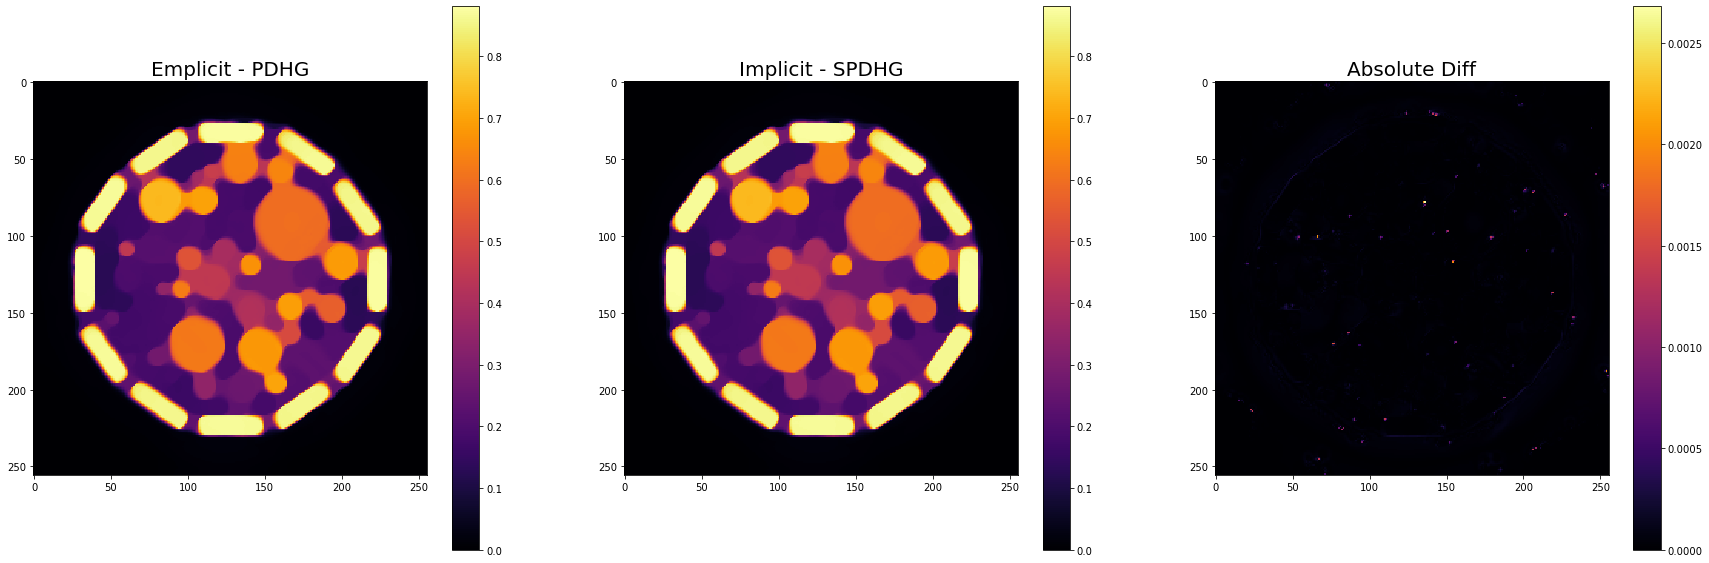

In [8]:
plt.figure(figsize=(30,10))

plt.subplot(1,3,1)
plt.imshow(pdhg_implicit_tv_precond.get_output().as_array(), cmap = 'inferno')
plt.title('Emplicit - PDHG', fontsize=20)
plt.colorbar()

plt.subplot(1,3,2)
plt.imshow(spdhg_implicit_tv_precond.get_output().as_array(), cmap = 'inferno')
plt.title('Implicit - SPDHG', fontsize=20)
plt.colorbar()


plt.subplot(1,3,3)
plt.imshow((spdhg_implicit_tv_precond.get_output()-pdhg_implicit_tv_precond.get_output()).abs().as_array(), cmap = 'inferno')
plt.title('Absolute Diff', fontsize=20)
plt.colorbar()
